# Imports

In [33]:
import random
import math
import pygame
import itertools
import networkx as nx
import copy
import time
import os
import matplotlib.pyplot as plt
import json

Nous souhaitons préciser que les parties 1 et 3 de notre projet partagent des classes en commun. Ainsi, certaines méthodes sont indispensables aux deux parties.

## Partie 1
____________

#### Classe des tâches

#### Classe des taxis
- Les heuristiques d'insertion étudiées dans la classe des taxis ainsi que les différentes protocoles de négoctiation utiles pour l'allocation des tâches ont été développées dans la partie 3, tandis que le reste correspond à la partie 1 du projet.

#### Classe de l'environnement
- Plusieurs algorithmes permettent de calculer l'ordonnancement des tâches :
    - `optimize_task_order` : Version optimale effectuant toutes les permutations possibles jusqu'à trouver le coût minimal.
    - `optimize_task_order_christofides` : Une solution approchée (rapport 3/2), très efficace en termes de temps d'exécution.
    - `greedy_task_order` : Version simple d'ordonnancement, loin de l'optimal mais rapide en termes de temps d'exécution.
- Paramètres:
    - `grid_size` : Taille de l'environnement
    - `num_taxis` : Nombre de taxis
    - `task_frequency` : Fréquence de création de tâches
    - `task_number` : Nombre de tâches à générer, >= num_taxis
    - `num_iterations` : Nombre d'itérations de la simulation
    - `delay` : Délai d'un nombre de secondes de la visualisation
    

#### Fonction de simulation
- `run_simulation` :
    - `allocation_method` : Définit la méthode d'allocation, codée dans la partie 3.
    - `ordonancement_method` : Définit la méthode d'ordonnancement.
    - `visualisation` : Si `True`, lance l'interface graphique ; si `False`, exécute sans visualisation.
    - `delay` : Lors de la visualisation, ce paramètre ralentit l'exécution pour suivre le déroulement. À ajuster selon les besoins.
    - `step_by_step` : Si `True`, permet de lancer une simulation pas à pas en appuyant sur la touche "Entrée".
    - `verbose` : Si `True`, affiche des informations complémentaires lorsque la simulation est exécutée sans visualisation.

____________






## Partie 2
____________

La partie 2 consiste en la création d'une fonction permettant de générer un fichier YAML (DCOP), adapté aux paramètres de la classe environnement présentée dans la partie 1.

- `generate_file_yaml` : Fonction permettant de modéliser le problème d'allocation des tâches des taxis sous forme de DCOP.

____________

## Partie 3
____________

#### Classe des taxis

- Heuristiques d'insertion (ajoutes dans la classe des taxis de la partie 1)
    - `prim_heuristic` : Heuristique de Prim
    - `insert_task_heuristic` : Heurisique d'insertion

#### Classe de l'environnement

- Les différentes protocoles de négoctiation pour l'allocation des tâches:
    - `allocate_tasks_psi` : PSI
    - `allocate_tasks_ssi` : SSI
    - `allocate_tasks_ssi_with_regret` : SSI avec regret

- Et d'autres allocations:
    - `allocate_tasks_random` : Allocation aléatoire
    - `allocate_tasks_opti` : Version optimale effectuant toutes les permutations possibles jusqu'à trouver le coût minimal.
____________

# La classe de taches

In [2]:
class Task:
    def __init__(self, start, end):
        self.start = start  # Position de départ (x, y)
        self.end = end      # Position d'arrivée (x, y)
        self.cost = self.calculate_distance(start, end)

    def calculate_distance(self, pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

    def __repr__(self):
        return f"Task(start={self.start}, end={self.end}, cost={self.cost:.2f})"

# La classe de taxis

In [3]:
class Taxi:
    def __init__(self, taxi_id, position, heuristic_method=0):
        self.taxi_id = taxi_id
        self.position = position  # Position actuelle (x, y)
        self.tasks = []           # Liste des tâches allouées
        self.total_cost = 0       # Coût total
        self.trajectory = []      # Liste des trajectoires pour visualisation
        self.current_task_index = 0  # Index de la tâche en cours
        self.finished_trajectory = []  # Trajectoires terminées pour affichage
        self.recent_trajectory = []  # Trajectoires terminées récemment
        self.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))  # Couleur aléatoire pour chaque taxi
        self.heuristic_method = heuristic_method  # Méthode heuristique par défaut

    def calculate_distance(self, pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

    # def assign_task(self, task):
    #     """Assigner une tâche au taxi et mettre à jour le coût."""
    #     self.tasks.append(task)

    #     #self.total_cost += self.calculate_distance(self.position, task.start) + self.calculate_distance(task.start, task.end)

    #     # Ajouter la trajectoire vers la position de départ et la destination
    #     self.trajectory.append((self.position, task.start))
    #     self.trajectory.append((task.start, task.end))

    def execute_task(self):
        """Exécuter la tâche en cours et gérer les trajectoires."""
        if self.current_task_index < len(self.tasks):
            task = self.tasks[self.current_task_index]

            # Si le taxi doit d'abord se rendre au point de départ
            if self.position != task.start:
                self.recent_trajectory.append((self.position, task.start))
                old_position = self.position
                self.position = task.start
                #print(f"Taxi {self.taxi_id} moved from position {old_position} to position {self.position}")
            else:
                # Aller à la destination
                self.recent_trajectory.append((self.position, task.end))
                old_position = self.position
                self.position = task.end
                #print(f"Taxi {self.taxi_id} moved from position {old_position} to position {self.position}")

                # Passer à la tâche suivante
                self.current_task_index += 1
        
    def update_trajectories(self):
        """Mettre à jour les trajectoires pour les afficher un pas de temps supplémentaire."""
        self.finished_trajectory.extend(self.recent_trajectory)
        self.recent_trajectory = []  # Réinitialiser les nouvelles trajectoires

        
    def reset_finished_trajectory(self):
        """Réinitialiser la trajectoire terminée."""
        self.finished_trajectory = []

    def __repr__(self):
        return f"Taxi(id={self.taxi_id}, position={self.position}, total_cost={self.total_cost:.2f})"
    
    # def calculate_marginal_cost(self, task):
    #     """Calcule le coût marginal d'ajout de cette tâche au plan actuel."""
    #     current_cost = self.total_cost
    #     all_tasks = self.tasks + [task]
    #     start_position = self.position if not self.tasks else self.tasks[-1].end
        
    #     # Optimiser l'ordre des tâches pour le taxi choisi
    #     optimized_order, optimized_cost = env.optimize_task_order(all_tasks, start_position)

    #     marginal_cost = optimized_cost - current_cost
    #     return marginal_cost


    # Les 2 methodes du cours: Heuristique de Prim et Heuristique par insertion
    def prim_heuristic(self, task):
        """Calculer le coût minimum (marginal) pour rejoindre le point de départ d'une tâche."""
        initial_position = self.position if not self.tasks else self.tasks[-1].end
        min_cost = self.calculate_distance(initial_position, task.start)
        for t in self.tasks:
            min_cost = min(min_cost, self.calculate_distance(t.end, task.start))
        return min_cost

    def insert_task_heuristic(self, task):
        """Calculer le coût minimum pour insérer une tâche dans le plan actuel."""
        pos0 = self.position if not self.tasks else self.tasks[-1].end
        min_cost = float('inf')

        # Cas particulier : aucune tâche encore assignée
        if len(self.tasks) == 0:
            return self.calculate_distance(pos0, task.start) + self.calculate_distance(task.start, task.end)

        # Insertion entre deux tâches existantes
        for i in range(len(self.tasks)):
            pos1 = self.tasks[i].start
            pos2 = self.tasks[i].end
            cost = (
                self.calculate_distance(pos0, pos1) +
                self.calculate_distance(task.start, pos1) +
                self.calculate_distance(task.end, pos2)
            )
            min_cost = min(min_cost, cost)

        # Insertion au début des tâches
        distance_initial = self.calculate_distance(pos0, self.tasks[0].start)
        distance_with_task = self.calculate_distance(task.end, self.tasks[0].start)
        min_cost = min(min_cost, distance_initial + distance_with_task)

        # Insertion à la fin des tâches
        distance_initial = self.calculate_distance(self.tasks[-1].end, pos0)
        distance_with_task = self.calculate_distance(self.tasks[-1].end, task.start)
        min_cost = min(min_cost, distance_initial + distance_with_task)

        return min_cost
    
    def heuristic(self, task):
        if self.heuristic_method == 0: # Prim
            return self.prim_heuristic(task)
        elif self.heuristic_method == 1: # Insertion
            return self.insert_task_heuristic(task)

    def bid_heuristic(self, task, heuristic_method):
        """Calculer l'enchère pour une tâche donnée."""
        self.heuristic_method = heuristic_method
        return self.heuristic(task)

    def assign_task(self, task):
        """Assigner une tâche au taxi et optimiser l'ordre des tâches."""
        self.tasks.append(task)
        #start_position = self.position if not self.tasks else self.tasks[-1].end

        self.trajectory.append((self.position, task.start))
        self.trajectory.append((task.start, task.end))

        # Mettre a jour le cout total
        self.total_cost += self.calculate_distance(self.position, task.start) + self.calculate_distance(task.start, task.end)

        # Pas besoin de le faire, c'est fait dans le lancement du code, après l'allocation des tâches
        #self.tasks, _ = env.optimize_task_order(self.tasks, start_position) # Reordonner les tâches pour minimiser le coût


# La classe de l'environnement

In [4]:
class Environment:
    def __init__(self, grid_size, num_taxis, task_frequency, task_number, num_iterations, heuristic_method=0,random_seed=None):
        self.grid_size = grid_size
        self.num_taxis = num_taxis
        self.task_frequency = task_frequency  # Fréquence d'arrivée des tâches (T)
        self.task_number = task_number  # Nombre de tâches à générer
        self.num_iterations = num_iterations  # Nombre total d'itérations
        self.random_seed=random_seed
        self.taxis = [Taxi(taxi_id=i, position=self.random_position(),heuristic_method=heuristic_method) for i in range(num_taxis)]
        self.tasks = []  # Liste des tâches en attente
        self.time = 0    # Temps actuel
        #self.delay = delay  # Délai en millisecondes pour ralentir l'exécution (nous n'en aurons plus besoin ici)
        self.heuristic_method = heuristic_method

    def random_position(self):
        """Générer une position aléatoire dans la grille."""
        return (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))

    def generate_tasks(self):
        """Générer des tâches aléatoires."""
        #num_tasks = random.randint(1, self.task_number)  # Par exemple, jusqu'à 1 tâche par taxi
        num_tasks=self.task_number
        new_tasks = [Task(start=self.random_position(), end=self.random_position()) for _ in range(num_tasks)]
        self.tasks.extend(new_tasks)
        #print(f"\n[Time {self.time}] Generated {len(new_tasks)} new tasks: {new_tasks}")
        
    def allocate_tasks(self, allocation_method=0):
        """Allouer les tâches aux taxis selon la méthode spécifiée."""
        if allocation_method == 0:
            self.allocate_tasks_random()
        elif allocation_method == 1: 
            self.allocate_tasks_opti()
        elif allocation_method == 2:
            self.allocate_tasks_psi(heuristic_method=self.heuristic_method)
        elif allocation_method == 3:
            self.allocate_tasks_ssi(heuristic_method=self.heuristic_method)
        elif allocation_method == 4:
            self.allocate_tasks_ssi_with_regret(heuristic_method=self.heuristic_method)

    def allocate_tasks_random(self,verbose=False):
        """Allouer les tâches aléatoirement aux taxis"""
        for task in self.tasks:
            random_taxi = random.choice(self.taxis)
            random_taxi.tasks.append(task)
            if verbose:
                print(f"Randomly assigned and optimized task {task} to Taxi {random_taxi.taxi_id}")
        
        # Vider la liste des tâches après l'allocation
        self.tasks = []

    # Tres lourd par rapport au temps, mais opti pour l'ordonnancement des tâches - surtout utilise pour tester la partie 1
    def allocate_tasks_opti(self,verbose=False):
        """Allouer les tâches aux taxis en minimisant les coûts par rapport a la fonction d'optimisation."""
        for task in self.tasks:
            costs = []

            for taxi in self.taxis:
                startx, starty = (taxi.position if not taxi.tasks else taxi.tasks[-1].end)
                all_tasks = [task] + taxi.tasks

                order, cost = self.optimize_task_order(all_tasks, (startx, starty))
                costs.append((cost, taxi, order))

            costs.sort(key=lambda x: x[0])
            best_cost, best_taxi, best_order = costs[0]
            best_taxi.tasks = best_order
            if verbose:
                print(f"Opti assigned task {task} to Taxi {best_taxi.taxi_id} with cost {best_cost:.2f}")

        self.tasks = []
    

    # Ordonancement des tâches
    def optimize_task_order(self, tasks, start_position):
        """Trouver l'ordre optimal des tâches pour minimiser le coût."""
        min_cost = float('inf')
        best_order = []

        #print("\nOptimizing task order:")
        #print(f"Initial tasks: {tasks}")
        #print(f"Start position: {start_position}")

        for permutation in itertools.permutations(tasks):
            current_position = start_position
            total_cost = 0

            #print(f"\nTesting permutation: {permutation}")
            for task in permutation:
                distance_to_start = self.calculate_distance(current_position, task.start)
                distance_to_end = self.calculate_distance(task.start, task.end)
                total_cost += distance_to_start + distance_to_end
                current_position = task.end
                #print(f"  Moving to {task.start}: +{distance_to_start:.2f}")
                #print(f"  Completing task to {task.end}: +{distance_to_end:.2f}")

            #print(f"  Total cost for this permutation: {total_cost:.2f}")

            if total_cost < min_cost:
                min_cost = total_cost
                best_order = list(permutation)
                #print(f"  New best order found with cost {min_cost:.2f}")

        #print(f"\nBest order: {best_order} with minimum cost: {min_cost:.2f}")
        return best_order, min_cost
    
    # TODO - algo Christofides pour l'ordonancement des tâches pour qu'il soit plus efficace en temps d'execution, mais pas optimal(3/2-approché)
    def optimize_task_order_christofides(self, tasks, start_position):
        if tasks == []:
            return [], 0
        
        # Step 1: Create a weighted graph where tasks are nodes
        graph = nx.Graph()
        task_indices = {i: task for i, task in enumerate(tasks)}
        # Add weighted edges for all task pairs
        for i, j in itertools.combinations(range(len(tasks)), 2):
            task_i, task_j = task_indices[i], task_indices[j]
            cost = (
                self.calculate_distance(start_position, task_i.start)
                + self.calculate_distance(task_i.end, task_j.start)
                + self.calculate_distance(task_j.start, task_j.end)
            )
            graph.add_edge(i, j, weight=cost)

        # Step 2: Find Minimum Spanning Tree (MST)
        mst = nx.minimum_spanning_tree(graph, weight="weight")

        # Step 3: Find vertices with odd degree
        odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 == 1]
        
        
        if len(odd_degree_nodes) < 2:
            raise ValueError("Graph does not have enough odd-degree nodes for matching.")

        # Step 4: Solve Minimum Weight Perfect Matching for odd-degree nodes
        odd_graph = graph.subgraph(odd_degree_nodes)
        matching = nx.algorithms.matching.min_weight_matching(odd_graph, weight="weight")

        # Step 5: Combine MST and Matching
        multigraph = nx.MultiGraph(mst)
        multigraph.add_edges_from(matching)
        
         # Verify if the graph is Eulerian
        if not nx.is_connected(multigraph):
            raise ValueError("The multigraph is not connected.")
        if any(degree % 2 != 0 for _, degree in multigraph.degree()):
            raise ValueError("The multigraph is not Eulerian (contains odd-degree nodes).")
        

        # Step 6: Find an Eulerian circuit
        eulerian_circuit = list(nx.eulerian_circuit(multigraph))

        # Step 7: Convert Eulerian circuit to Hamiltonian path
        visited = set()
        tsp_order = []
        for u, v in eulerian_circuit:
            if u not in visited:
                tsp_order.append(u)
                visited.add(u)
        tsp_order.append(tsp_order[0])  # Return to start

        # Translate TSP order back to tasks
        best_order = [task_indices[i] for i in tsp_order[:-1]]

        # Compute total cost
        current_position = start_position
        total_cost = 0
        for task in best_order:
            total_cost += self.calculate_distance(current_position, task.start)
            total_cost += self.calculate_distance(task.start, task.end)
            current_position = task.end

        return best_order, total_cost

    # Greedy task order
    # A tester
    def greedy_task_order(self, tasks, start_position):
        order = []
        current_position = start_position
        while tasks:
            closest_task = min(tasks, key=lambda task: self.calculate_distance(current_position, task.start))
            order.append(closest_task)
            current_position = closest_task.end
            tasks.remove(closest_task)
        return order, sum(self.calculate_distance(t1.end, t2.start) for t1, t2 in zip(order[:-1], order[1:]))
    
    def calculate_distance(self, pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)
    

    # Partie 3 

    # PSI
    def allocate_tasks_psi(self, heuristic_method=0,verbose=False):
        """Allocation des tâches avec enchères parallèles (PSI)."""
        task_allocations = {taxi: [] for taxi in self.taxis}

        # Chaque taxi soumet une enchère pour chaque tâche
        for task in self.tasks:
            if verbose:
                print(f"\nProcessing task {task}:")

            # Calculer les enchères pour tous les taxis
            bids = [(taxi.bid_heuristic(task, heuristic_method), taxi) for taxi in self.taxis]
            for bid, taxi in bids:
                if verbose:
                    print(f"  Taxi {taxi}: Bid = {bid}")

            # Trier les enchères par coût croissant
            bids.sort(key=lambda x: x[0])
            winner = bids[0][1]  # Le taxi avec la meilleure enchère remporte la tâche
            winner.tasks.append(task)
            if verbose:
                print(f"  Winner for task {task}: Taxi {winner}")

            # Ajouter la tâche au taxi gagnant
            task_allocations[winner].append(task)

        if verbose:
            # Assigner les tâches aux taxis
            for taxi in self.taxis:
                if task_allocations[taxi]:
                    print(f"\n[PSI] Assigning tasks to Taxi {taxi}: {task_allocations[taxi]}")
                    for task in task_allocations[taxi]:
                        taxi.assign_task(task)
                else:
                    print(f"\nTaxi {taxi} has no tasks assigned.")

        # Supprimer les tâches allouées de la liste des tâches disponibles
        allocated_tasks = [task for tasks in task_allocations.values() for task in tasks]
        self.tasks = [task for task in self.tasks if task not in allocated_tasks]

        # État final des taxis
        if verbose:
            print("\nFinal state of taxis:")
            for taxi in self.taxis:
                print(f"  Taxi {taxi}: Tasks = {taxi.tasks}")


    
    # SSI
    def allocate_tasks_ssi(self, heuristic_method=0,verbose=False):
        """Allocation des tâches avec enchères Sequential Single-item (SSI)."""
        task_allocations = {taxi: [] for taxi in self.taxis}
        taches_non_allocated = self.tasks

        while taches_non_allocated:
            taxis_bids = {taxi:None for taxi in self.taxis}
            # Chaque taxi soumet une enchère pour chaque tâche
            for taxi in self.taxis:
                bids = [(taxi.bid_heuristic(task, heuristic_method), taxi) for task in taches_non_allocated]
                best_bids = min(bids)
                ind_best_bids = bids.index(best_bids)
                taxis_bids[taxi] = (ind_best_bids, best_bids)

            winner = min(taxis_bids,key = lambda k: (taxis_bids[k][1][0],k.taxi_id))
            task_done = self.tasks[taxis_bids[winner][0]]
            if verbose:
                print(f"  Winner for task {task_done}: Taxi {winner}")
            winner.assign_task(task_done)
            taches_non_allocated.remove(task_done)

        # Supprimer les tâches allouées de la liste des tâches disponibles
        allocated_tasks = [task for tasks in task_allocations.values() for task in tasks]
        self.tasks = [task for task in self.tasks if task not in allocated_tasks]

        if verbose:
            # État final des taxis
            print("\n  Final state of taxis:")
            for taxi in self.taxis:
                print(f"  Taxi {taxi}: Tasks = {taxi.tasks}")

    # SSI avec regret
    def allocate_tasks_ssi_with_regret(self, heuristic_method=0,verbose=False):
        """Allocation des tâches avec enchères Sequential Single-item (SSI) en tenant compte des regrets."""
        task_allocations = {taxi: [] for taxi in self.taxis}
        taches_non_allocated = self.tasks

        while taches_non_allocated:
            # Étape 1: Collecter les bids pour chaque tâche de chaque taxi
            bids_matrix = {task: {} for task in taches_non_allocated}
            for task in taches_non_allocated:
                for taxi in self.taxis:
                    bids_matrix[task][taxi] = taxi.bid_heuristic(task, heuristic_method)

            # DEBUG - Afficher les bids pour chaque tâche et chaque taxi 
            #print("\nBids Matrix (per task and taxi):")
            #for task, bids in bids_matrix.items():
                #print(f"  Task {task}:")
                #for taxi, bid in bids.items():
                    #print(f"    Taxi {taxi}: Bid = {bid:.2f}")

            # Étape 2: Calculer les regrets pour chaque tâche
            regrets = {}
            for task, bids in bids_matrix.items():
                sorted_bids = sorted(bids.values()) # Trier les bids associés à une tâche donnée
                #print("sorted_bids: ",sorted_bids)
                # Calcul du regret comme la différence absolue entre les deux meilleures bids
                if len(sorted_bids) > 1:
                    regret = abs(sorted_bids[1] - sorted_bids[0])
                else:
                    regret = 0  # Si un seul taxi a fait une offre, il n'y a pas de regret
                regrets[task] = regret

            # Étape 3: Trouver la tâche avec le regret maximal
            # DEBUG - Afficher les regrets pour chaque tâche
            if verbose:
                print("\nRegrets for each task:")
                for task, regret in regrets.items():
                    print(f"  Task {task}: Regret = {regret:.2f}")
            #max_regret_task = max(regrets, key=regrets.get)
            max_regret_value = max(regrets.values())
            max_regret_tasks = [task for task, regret in regrets.items() if regret == max_regret_value]

            # Si plusieurs tâches ont le même regret, choisir une tâche aléatoirement
            max_regret_task = random.choice(max_regret_tasks)

            # Étape 4: Allouer la tâche avec regret maximal au taxi ayant fait l'offre minimale
            task_bids = bids_matrix[max_regret_task]
            winner = min(task_bids, key=task_bids.get)  # Taxi ayant proposé le bid minimum pour la tâche

            if verbose:
                print(f"Task {max_regret_task} assigned to Taxi {winner} with bid {task_bids[winner]} (Regret = {regrets[max_regret_task]})")

            # Assigner la tâche au taxi gagnant
            winner.assign_task(max_regret_task)
            taches_non_allocated.remove(max_regret_task)

        # Supprimer les tâches allouées de la liste des tâches disponibles
        allocated_tasks = [task for tasks in task_allocations.values() for task in tasks]
        self.tasks = [task for task in self.tasks if task not in allocated_tasks]

        # État final des taxis
        if verbose:
            print("\nFinal state of taxis:")
            for taxi in self.taxis:
                print(f"Taxi {taxi}: Tasks = {taxi.tasks}")
            
    def calculate_allocation_cost(self):
        """Calculate the total cost of task allocation across all taxis."""
        total_cost = 0

        for taxi in self.taxis:
            current_position = taxi.position  # Start from the taxi's initial position
            taxi_cost = 0

            for task in taxi.tasks:
                # Calculate the cost to reach the task's start
                cost_to_start = task.calculate_distance(current_position, task.start)
                # Calculate the cost to complete the task
                cost_to_end = task.calculate_distance(task.start, task.end)
            
                # Update taxi cost and current position
                taxi_cost += cost_to_start + cost_to_end
                current_position = task.end

            # Add this taxi's cost to the total cost
            total_cost += taxi_cost

            #print(f"Taxi {taxi.taxi_id} cost: {taxi_cost:.2f}")

        #print(f"Total allocation cost: {total_cost:.2f}")
        return total_cost

# La simulation

In [5]:
def run_simulation(env, allocation_method=0, ordonancement_method=0, visualisation=True, delay=0.5, step_by_step=True, verbose=False):
    
    if visualisation:
        pygame.init()
        
        # Configuration de l'affichage
        SCREEN_SIZE = 800
        screen = pygame.display.set_mode((SCREEN_SIZE, SCREEN_SIZE))
        pygame.display.set_caption("Taxi Task Allocation Simulation")
        clock = pygame.time.Clock()

        cell_size = SCREEN_SIZE // env.grid_size

        # Allouer les tâches
        env.allocate_tasks(allocation_method=allocation_method)

        if ordonancement_method == 0:
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.greedy_task_order(taxi.tasks, taxi.position)
        elif ordonancement_method == 1:
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.optimize_task_order(taxi.tasks, taxi.position)
        elif ordonancement_method == 2:
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.optimize_task_order_christofides(taxi.tasks, taxi.position)

        def draw_line(screen, start, end, color):
            pygame.draw.line(
                screen, color,
                (start[1] * cell_size + cell_size // 2, start[0] * cell_size + cell_size // 2),
                (end[1] * cell_size + cell_size // 2, end[0] * cell_size + cell_size // 2),
                3
            )

        def draw_grid(screen):
            font = pygame.font.SysFont("Arial", 12)
            for x in range(env.grid_size):
                for y in range(env.grid_size):
                    pygame.draw.line(screen, (0, 0, 0), (x * cell_size, 0), (x * cell_size, SCREEN_SIZE))
                    pygame.draw.line(screen, (0, 0, 0), (0, y * cell_size), (SCREEN_SIZE, y * cell_size))
            for x in range(env.grid_size):
                text = font.render(f"{x}", True, (0, 0, 0))
                screen.blit(text, (x * cell_size + cell_size // 2 - text.get_width() // 2, 0))
                screen.blit(text, (x * cell_size + cell_size // 2 - text.get_width() // 2, SCREEN_SIZE - text.get_height()))
            for y in range(env.grid_size):
                text = font.render(f"{y}", True, (0, 0, 0))
                screen.blit(text, (0, y * cell_size + cell_size // 2 - text.get_height() // 2))
                screen.blit(text, (SCREEN_SIZE - text.get_width(), y * cell_size + cell_size // 2 - text.get_height() // 2))

        running = True
        time_step = 0
        while running and time_step < env.num_iterations:
            if step_by_step:
                # En mode pas à pas, attendre une entrée utilisateur
                wait_for_keypress = True
                while wait_for_keypress:
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            running = False
                            wait_for_keypress = False
                        elif event.type == pygame.KEYDOWN and event.key == pygame.K_RETURN:
                            wait_for_keypress = False
            else:
                # En mode continu, ralentir selon le délai
                time.sleep(delay)
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False

            if time_step % env.task_frequency == 0:
                env.generate_tasks()
            if env.tasks:
                env.allocate_tasks(allocation_method=allocation_method)

            screen.fill((255, 255, 255))
            draw_grid(screen)
            
            for taxi in env.taxis:
                taxi.update_trajectories()
                for line in taxi.finished_trajectory:
                    draw_line(screen, line[0], line[1], taxi.color)
                for line in taxi.recent_trajectory:
                    draw_line(screen, line[0], line[1], (0, 0, 0))
                pygame.draw.circle(
                    screen, taxi.color,
                    (taxi.position[1] * cell_size + cell_size // 2, taxi.position[0] * cell_size + cell_size // 2),
                    10
                )
                font = pygame.font.SysFont("Arial", 14)
                text = font.render(f"Taxi {taxi.taxi_id}", True, (0, 0, 0))
                screen.blit(
                    text,
                    (taxi.position[1] * cell_size + cell_size // 2 - text.get_width() // 2,
                     taxi.position[0] * cell_size + cell_size // 2 - 20)
                )
                taxi.execute_task()
                if not taxi.tasks or taxi.current_task_index >= len(taxi.tasks):
                    taxi.reset_finished_trajectory()

            pygame.display.flip()
            env.time += 1
            time_step += 1

        pygame.quit()

    else:
        # Initial setup
        time_step = 0

        # Allocate tasks
        env.allocate_tasks(allocation_method=allocation_method)

        if ordonancement_method == 0:
            # Task scheduling for each taxi
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.greedy_task_order(taxi.tasks, taxi.position)
        elif ordonancement_method == 1:
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.optimize_task_order(taxi.tasks, taxi.position)
        elif ordonancement_method == 2:
            for taxi in env.taxis:
                taxi.tasks, taxi.total_cost = env.optimize_task_order_christofides(taxi.tasks, taxi.position)

        #print("Starting simulation...\n")

        while time_step < env.num_iterations:
            if verbose:
                print(f"Time step {time_step}:\n")

            # Generate tasks at the appropriate intervals
            if time_step % env.task_frequency == 0:
                env.generate_tasks()

            if env.tasks:
                env.allocate_tasks(allocation_method=allocation_method)

            for taxi in env.taxis:
                if verbose:
                    print(f"  Taxi {taxi.taxi_id}:")

                # Update trajectories
                taxi.update_trajectories()

                # Display finished trajectory
                if taxi.finished_trajectory and verbose:
                    print(f"    Finished trajectory: {taxi.finished_trajectory}")

                # Display recent trajectory
                if taxi.recent_trajectory and verbose:
                    print(f"    Recent trajectory: {taxi.recent_trajectory}")

                # Display current position
                if verbose:
                    print(f"    Current position: {taxi.position}")

                # Execute the next task
                taxi.execute_task()

                if verbose:
                    # Display remaining tasks
                    print(f"    Remaining tasks: {taxi.tasks}")

                # Reset finished trajectory if no tasks remain
                if not taxi.tasks or taxi.current_task_index >= len(taxi.tasks):
                    taxi.reset_finished_trajectory()

            if verbose:
                print("\n-----------------------------\n")

            # Increment time
            env.time += 1
            time_step += 1

        #print("Simulation complete.")

# Tests sur la simulation

Dans cette partie, vous pouvez modifier les paramètres pour tester une simulation avec ou sans visualisation.

In [6]:
GRID_SIZE = 20
NUM_TAXIS = 3
TASK_FREQUENCY = 8
TASK_NUMBER = 5# Nombre de tâches à générer, >= NUM_TAXIS
NUM_ITERATIONS = 30
DELAY = 1  # Délai de 1 seconde(s)

env = Environment(grid_size=GRID_SIZE, num_taxis=NUM_TAXIS, task_frequency=TASK_FREQUENCY, task_number=TASK_NUMBER, num_iterations=NUM_ITERATIONS,heuristic_method=1)

ALLOCATION_METHOD = 3  # 0 pour aléatoire, 1 pour Opti, 2 pour PSI, 3 pour SSI, 4 SSI avec regret
HEURISTIC_METHOD = 0  # 0 pour Prim, 1 pour Insertion
ORDONANCEMENT_METHOD = 1 # 0 pour Greedy, 1 pour Opti, 2 pour Christoficides
run_simulation(env, allocation_method=ALLOCATION_METHOD, ordonancement_method=ORDONANCEMENT_METHOD, visualisation=True, delay=DELAY, step_by_step=True, verbose=False)


# PYDCOP

Génération d'un fichier YAML pour modéliser notre problème comme un DCOP, afin de le résoudre avec la bibliothèque PYDCOP.

In [6]:
def generate_file_yaml(env,nom_fic):
    list_taxis_env=env.taxis
    list_taches_env=env.tasks
    list_taxi=[]
    list_taches=[]
    for i in range(1,len(list_taxis_env)+1):
        list_taxi.append(f"taxi_{i}")
    
    for i in range(1,len(list_taches_env)+1):
        list_taches.append(f"task_{i}")
        
    with open(nom_fic,"w") as f:
        f.write("name: Taxi Task Allocation Problem \n")
        f.write("objective: min \n")
        f.write("\n")

        #Ecriture des domaines dans le fichier yaml
        f.write("domains: \n")
        f.write("   taxis: \n" )
        f.write("      values: ")
        f.write("[")
        for i in range(len(list_taxi)):
            f.write(list_taxi[i])
            if i<len(list_taxi)-1:
                f.write(",")
        f.write("]\n")
        f.write("\n")

        #Ecriture des variables dans le fichier yaml
        f.write("variables: \n")
        for tache in list_taches:
            f.write("   ")
            f.write(tache)
            f.write(" : \n")
            f.write("      domain: taxis \n")
        f.write("\n")

        f.write("constraints: \n")
        for i in range(len(list_taches)):
            f.write(f"   pref_{i+1}: \n")
            f.write("      type: extensional \n")
            f.write(f"      variables: {list_taches[i]} \n")
            f.write("      values: \n")
            for j in range(len(list_taxi)):
                f.write(f"         {j+1}: {list_taxi[j]} \n")
            f.write("\n")
        
        for i in range(len(list_taches)):
            for j in range(len(list_taches)):
                if i<j:
                    f.write(f"   different_{list_taches[i]}_{list_taches[j]}: \n")
                    f.write("      type: intention \n")
                    cout=list_taches_env[i].calculate_distance(list_taches_env[i].end,list_taches_env[j].start)
                    f.write(f"      function: {cout} if {list_taches[i]}=={list_taches[j]} else 0 \n")
                    f.write("\n")
        
        for i in range(len(list_taxi)):
            f.write(f"   cout_{list_taxi[i]}: \n")
            f.write("      type: intention \n")
            f.write(f"      function: {list_taches_env[0].cost+list_taxis_env[i].calculate_distance(list_taxis_env[i].position,list_taches_env[0].start)} if {list_taches[0]}=='{list_taxi[i]}'")
            for j in range(1,len(list_taches)-1):
                f.write(f" else {list_taches_env[j].cost+list_taxis_env[i].calculate_distance(list_taxis_env[i].position,list_taches_env[j].start)} if {list_taches[j]}=='{list_taxi[i]}'")
            if len(list_taches)>1:
                f.write(f" else {list_taches_env[-1].cost+list_taxis_env[i].calculate_distance(list_taxis_env[i].position,list_taches_env[-1].start)}")
            f.write("\n")
        
        f.write("\n")
        f.write(f"agents: \n")
        for i in range(len(list_taches)):
            f.write(f"   {list_taches[i]}: \n")
            f.write("      capacity: 1 \n")       

In [55]:
GRID_SIZE = 20
NUM_TAXIS = 3
TASK_FREQUENCY = 5
NUM_ITERATIONS = 30
TASK_NUMBER = 6 # Nombre de tâches à générer, >= NUM_TAXIS

env=Environment(grid_size=GRID_SIZE, num_taxis=NUM_TAXIS, task_frequency=TASK_FREQUENCY, task_number=TASK_NUMBER,num_iterations=NUM_ITERATIONS)
env.generate_tasks()
generate_file_yaml(env,"freq.yaml")

In [12]:
def generate_files(output_dir,nb_simulation):
    GRID_SIZE = 20
    NUM_TAXIS = 3
    TASK_FREQUENCY = 5
    NUM_ITERATIONS = 30
    TASK_NUMBER = 3 # Nombre de tâches à générer, >= NUM_TAXIS
    
    for sim in range(nb_simulation):

        env=Environment(grid_size=GRID_SIZE, num_taxis=NUM_TAXIS, task_frequency=TASK_FREQUENCY, task_number=TASK_NUMBER,num_iterations=NUM_ITERATIONS)

        # Initial setup
        time_step = 0


        while time_step < env.num_iterations:

            # Generate tasks at the appropriate intervals
            if time_step % env.task_frequency == 0:
                env.tasks=[]
                env.generate_tasks()
                generate_file_yaml(env,f"{output_dir}/inst_{sim+1}_{time_step}.yaml")


            # Increment time
            env.time += 1
            time_step += 1


In [13]:
output_dir = "fichiers_3_taxis_3_taches"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)


generate_files(output_dir,10)

In [ ]:
def lire_donnes(results_dir):

    # Define where results are stored
    time_avg=0
    cout_avg=0


    #Iterate over all instances
    for i in range(1, 11):
        instance_folder = f"{results_dir}/inst_{i}"
        time_exec_i=0
        cout_i=0
    
        # Iterate over all generations (0, 5, 10, ..., 25)
        for j in range(0, 30, 5):
            result_file = f"{instance_folder}/result_{j}"
        
            if not os.path.exists(result_file):
                print(f"Skipping missing file: {result_file}")
                continue
        
            with open(result_file, "r") as f:
                content = json.load(f)  # Load JSON
                cost = content.get("cost", None)
                execution_time = content.get("time", None)
                cout_i=+cost
                time_exec_i=+execution_time
                
            # Store in list
        time_avg=+time_exec_i
        cout_avg=+cout_i
    
    return time_avg,cout_avg



In [35]:
time_1_dpop,cout_1_dpop=lire_donnes("results_dpop_3_taxis_3_taches")
time_2_dpop,cout_2_dpop=lire_donnes("results_dpop_3_taxis_6_taches")
time_3_dpop,cout_3_dpop=lire_donnes("results_dpop_3_taxis_9_taches")
time_1_adopt,cout_1_adopt=lire_donnes("results_adopt_3_taxis_3_taches")
time_2_adopt,cout_2_adopt=lire_donnes("results_adopt_3_taxis_6_taches")
time_3_adopt,cout_3_adopt=lire_donnes("results_adopt_3_taxis_9_taches")

cout_list=[[cout_1_dpop,cout_2_dpop,cout_3_dpop],[cout_1_adopt,cout_2_adopt,cout_3_adopt]]
time_list=[[time_1_dpop,time_2_dpop,time_3_dpop],[time_1_adopt,time_2_adopt,time_3_adopt]]

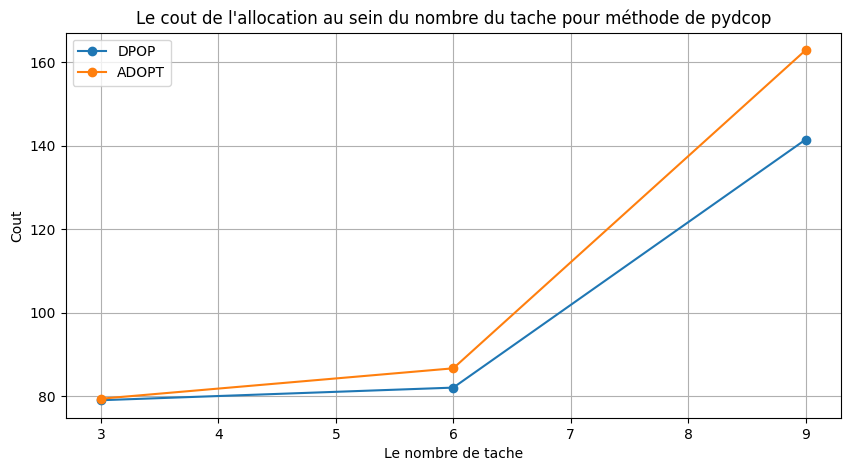

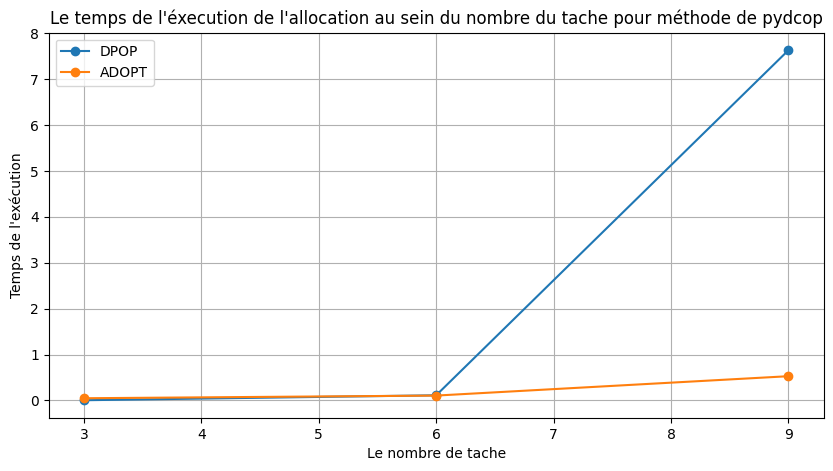

In [36]:
# Plot cost improvement

n_values=[3,6,9]
plt.figure(figsize=(10, 5))
methods=["DPOP","ADOPT"]
for method in range(2):
    plt.plot(n_values, cout_list[method], marker='o', label=methods[method])
plt.xlabel("Le nombre de tache")
plt.ylabel('Cout')
plt.title("Le cout de l'allocation au sein du nombre du tache pour méthode de pydcop")
plt.legend()
plt.grid(True)
plt.savefig("Comparaison_cost_alloc_par_pydcop.png")
plt.show()

n_values=[3,6,9]
plt.figure(figsize=(10, 5))
methods=["DPOP","ADOPT"]
for method in range(2):
    plt.plot(n_values, time_list[method], marker='o', label=methods[method])
plt.xlabel("Le nombre de tache")
plt.ylabel("Temps de l'exécution")
plt.title("Le temps de l'éxecution de l'allocation au sein du nombre du tache pour méthode de pydcop")
plt.legend()
plt.grid(True)
plt.savefig("Comparaison_temps_alloc_par_pydcop.png")
plt.show()


# Experiments

In [6]:
def tournoi(base_env,random_seed=42):
    
    allocation_methods=[0,2,3,4]
    ordo=2
    results=[]
    exec_time=[]
    
    for alloc in allocation_methods:
        #print(f"Running simulation with Allocation Method {alloc} and Ordonnancement Method {ordo}...")
        #random.seed(random_seed)
        env = copy.deepcopy(base_env)
        random.seed(random_seed)
        start_time=time.time()
        run_simulation(env,allocation_method=alloc,ordonancement_method=ordo,visualisation=False)
        exec_time.append(time.time()-start_time)
        cost=env.calculate_allocation_cost()
        results.append(cost)
    
    return results,exec_time
    
    

In [57]:
GRID_SIZE = 20
NUM_TAXIS = 3
TASK_FREQUENCY = 8
TASK_NUMBER = 15
NUM_ITERATIONS = 30


couts={
    "Allocation Random":0,
    "Allocation PSI":0,
    "Allocation SSI":0,
    "Allocation SSI avec regret":0
}

temps_execution={
    "Allocation Random":0,
    "Allocation PSI":0,
    "Allocation SSI":0,
    "Allocation SSI avec regret":0
}

num_test=100

for i in range(num_test):
    seed=i
    base_env = Environment(grid_size=GRID_SIZE, num_taxis=NUM_TAXIS, task_frequency=TASK_FREQUENCY, task_number=TASK_NUMBER, num_iterations=NUM_ITERATIONS,heuristic_method=1,random_seed=seed)
    results,exectime=tournoi(base_env,random_seed=seed)
    couts["Allocation Random"]+=results[0]
    couts["Allocation PSI"]+=results[1]
    couts["Allocation SSI"]+=results[2]
    couts["Allocation SSI avec regret"]+=results[3]
    temps_execution["Allocation Random"]+=exectime[0]
    temps_execution["Allocation PSI"]+=exectime[1]
    temps_execution["Allocation SSI"]+=exectime[2]
    temps_execution["Allocation SSI avec regret"]+=exectime[3]

couts = {key: value / num_test for key, value in couts.items()}
temps_execution={key: value / num_test for key, value in temps_execution.items()}

In [10]:
NUM_TAXIS = 10
TASK_FREQUENCY = 8
NUM_ITERATIONS = 30
TASK_NUMBER=100
data_num_tasks={}

for grid_size in [10,20,50]:
    couts={
        "Allocation Random":0,
        "Allocation PSI":0,
        "Allocation SSI":0,
        "Allocation SSI avec regret":0
    }

    temps_execution={
        "Allocation Random":0,
        "Allocation PSI":0,
        "Allocation SSI":0,
        "Allocation SSI avec regret":0
    }

    num_test=100
    GRID_SIZE=grid_size

    for i in range(num_test):
        seed=i
        base_env = Environment(grid_size=GRID_SIZE, num_taxis=NUM_TAXIS, task_frequency=TASK_FREQUENCY, task_number=TASK_NUMBER, num_iterations=NUM_ITERATIONS,heuristic_method=1,random_seed=seed)
        results,exectime=tournoi(base_env,random_seed=seed)
        couts["Allocation Random"]+=results[0]
        couts["Allocation PSI"]+=results[1]
        couts["Allocation SSI"]+=results[2]
        couts["Allocation SSI avec regret"]+=results[3]
        temps_execution["Allocation Random"]+=exectime[0]
        temps_execution["Allocation PSI"]+=exectime[1]
        temps_execution["Allocation SSI"]+=exectime[2]
        temps_execution["Allocation SSI avec regret"]+=exectime[3]

    couts = {key: value / num_test for key, value in couts.items()}
    temps_execution={key: value / num_test for key, value in temps_execution.items()}
    data_num_tasks[grid_size]=(couts,temps_execution)

In [ ]:
methods = ['Allocation Random', 'Allocation PSI', 'Allocation SSI', 'Allocation SSI avec regret']
n_values = list(data_num_tasks.keys())

# Extract costs and times
costs = {method: [data_num_tasks[n][0][method] for n in n_values] for method in methods}
times = {method: [data_num_tasks[n][1][method] for n in n_values] for method in methods}

# Plot cost improvement
plt.figure(figsize=(10, 5))
for method in methods:
    plt.plot(n_values, costs[method], marker='o', label=method)
plt.xlabel('La taille de grille')
plt.ylabel('Cout')
plt.title("Le cout de l'allocation au sein de la taille de grille pour méthode d'allocation")
plt.legend()
plt.grid(True)
plt.savefig("Comparaison_cost_alloc_par_grille.png")
plt.show()

# Plot execution time
plt.figure(figsize=(10, 5))
for method in methods:
    plt.plot(n_values, times[method], marker='o', label=method)
plt.xlabel('La taille de grille')
plt.ylabel('Execution Time (seconds)')
plt.title("Le temps de l'execution au sein de la taille de grille pour méthode d'allocation")
plt.yscale('log')  # Log scale for better visualization
plt.legend()
plt.grid(True)
plt.savefig("Comparaison_time_exec_par_grille.png")
plt.show()
